In this notebook, I want to explore what it means when the difference between 2 positive definite matrices to be positive definite.
To do this, I will generate a positive definite, covariance matrices $G$ and $H$, and I will look at the difference $D=H-G$.

We have pretty good intuition on the geometric representation of covariance matrix in parameter space.
We will use this knowledge to understand the positive definite condition of $D$.

To simplify the analysis, we will only look at 2D parameter space.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
import os

seed = 2023
np.random.seed(seed)
%matplotlib inline
plt.style.use("default")

To generate a covariance matrix, we generate a random, $M \times N$ Jacobian matrix $J$, where $M \geq N$.
Then, we get the covariance matrix by taking $J^T J$.

In [2]:
def generate_pd_matrix(dim):
    """A function to generate a positive definite covariance matrix."""
    M = np.random.randint(dim, 2 * dim)
    rand_mat = np.random.randn(M, dim)
    H = rand_mat.T @ rand_mat
    return H

# Test the function
H = generate_pd_matrix(np.random.randint(1, 10))
np.all(np.linalg.eigvalsh(H) >= 0.0)

True

As preliminary, we will look at the geometric interpretation of the covariance matrix.
We will use 2D parameter space, thus the covariance matrix is a $2 \times 2$ matrix.

In [3]:
N = 2
G = generate_pd_matrix(N)
lg, vg = np.linalg.eigh(G)
print(lg)

[1.13679693 3.51512899]


First, note that the eigenvalues of the covariance matrix are all positive, as expected.

Next, we will plot the covariance matrix.
If we plot the 2D Gaussian distribution as a contour plot in parameter space, we will see that the contours look like ellipses.
The eigenvectors of the covariance matrix describe the direction of the semi-major and semi-minor axes of these ellipses, and the lengths of the axes are $\propto 1 / \sqrt{\lambda}$

Below, we will plot the eigenvectors scaled by $\propto 1 / \sqrt{\lambda}$ and the corresponding ellipse.

In [4]:
quiver_kwargs = dict(units="inches", scale_units="inches")


def rot2d(theta):
    """Generate a 2D rotation matrix given the angle in radians."""
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


def ellipse_data(l, v):
    """Given the eigenvalues and eigenvectors, generate data to plot an ellipse."""
    a, b = np.sqrt(np.abs(l))
    t = np.linspace(0, 2 * np.pi, 100)
    Ell = np.array([a * np.cos(t), b * np.sin(t)])
    angle = np.arctan(v[1, 0] / v[0, 0])
    Rrot = rot2d(angle)
    Ell_rot = Rrot @ Ell
    return Ell_rot


def plot_cov_matrix(ax, l, v, color, label):
    """Plot the eigenvalues and eigenvectors of the covariance matrix."""
    ax.quiver(
        *np.zeros((2, N)),
        *v,
        scale=1 / np.sqrt(np.abs(l)),
        **quiver_kwargs,
        color=color,
        label=label
    )
    Ell = ellipse_data(l, v)
    ax.plot(Ell[0, :], Ell[1, :], c=color)

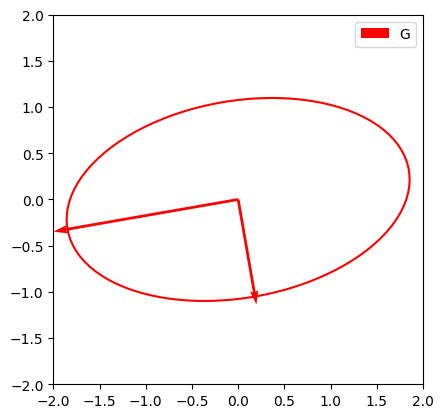

In [5]:
plt.figure()
plot_cov_matrix(plt.gca(), lg, vg, "r", "G")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect("equal", "box")
plt.legend()
plt.show()

Next, let's generate 2 random covariance matrix and look at the difference between the two.

In [6]:
G = generate_pd_matrix(N)
lg, vg = np.linalg.eigh(G)
H = generate_pd_matrix(N)
lh, vh = np.linalg.eigh(H)
D = H - G
ld, vd = np.linalg.eigh(D)
print(ld)

[-5.56111586  4.71600858]


Notice that $D=H-G$ is not necessarily a positive definite matrix.
We can also plot the eigenvectors of these 3 matrices, but this alone might not help us understand what is happening.

In [7]:
def plot_cov_matrices(ax, eigen_dict, box_ub=3):
    """Plot the eigenvectors of the 3 matrices: H, G, and D."""
    lg = eigen_dict["G"]["eigenvalues"]
    vg = eigen_dict["G"]["eigenvectors"]
    lh = eigen_dict["H"]["eigenvalues"]
    vh = eigen_dict["H"]["eigenvectors"]
    ld = eigen_dict["D"]["eigenvalues"]
    vd = eigen_dict["D"]["eigenvectors"]

    plot_cov_matrix(ax, lg, vg, "r", r"$G$")
    plot_cov_matrix(ax, lh, vh, "g", r"$H$")
    plot_cov_matrix(ax, ld, vd, "b", r"$H-G$")
    ax.set_xlim(-box_ub, box_ub)
    ax.set_ylim(-box_ub, box_ub)
    ax.set_aspect("equal", "box")

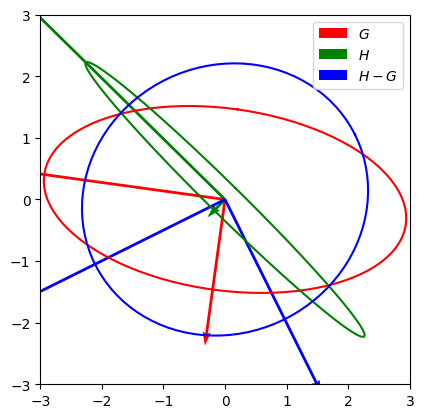

In [8]:
plt.figure()
eigen_dict = {
    "G": {"eigenvalues": lg, "eigenvectors": vg},
    "H": {"eigenvalues": lh, "eigenvectors": vh},
    "D": {"eigenvalues": ld, "eigenvectors": vd},
}
plot_cov_matrices(plt.gca(), eigen_dict)
plt.legend()
plt.show()

In general $H-G$ is not positive definite and I haven't found general criteria to check the positive definiteness of $H-G$.
However, there are special cases that we can consider.
1. In general, $H - G$ is not positive definite.
However, we can ensure positive definiteness of $H-G$ if
\begin{equation}
    \lambda_N^H > \lambda_1^G,
\end{equation}
where $\lambda_i^H$ and $\lambda_i^G$ are the eigenvalues of $H$ and $G$, respectively, and we have used a notation where $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_N$.
To see this, let $x$ be an arbitrary vector in $\mathbb{R}^N$.
Without loss of generality, let $\Vert x \Vert_2 = 1$.
If we want $H-G$ to be positive definite, then
\begin{equation}
    x^T (H-G) x = x^T H x - x^T G x > 0 \Rightarrow x^T H x > x^T G x,
\end{equation}
and to satisfy this expression for arbitrary $x$, then we must have
\begin{equation}
    \min(x^T H x) > \max(x^T G x).
\end{equation}
To find the bounds lower bound of $H$, consider the eigenvalue decomposition of $H$,
\begin{equation}
    H = V^H \Lambda^H {V^H}^T \quad.
\end{equation}
We can write an arbitrary vector $x\in \mathbb{R}^N$ as a linear combination of the eigenvectors of $H$,
\begin{equation}
    x = \sum_{i=1}^N a_i v_i^H, \text{ where } \vert a_i \vert \leq 1~\forall i \text{ and } \sum_{i=1}^N a_i^2 = 1.
\end{equation}
It can be shown that
\begin{equation}
    x^T H x = \sum_{i=1}^N \lambda_i^H a_i^2.
\end{equation}
From this expression, then we can see that $x^T H x$ is bounded by
\begin{equation}
    \lambda_1^H \geq x^T H x \geq \lambda_N^H.
\end{equation}
The upper bounds can be reached when $x = v_1^H$ and the lower bound can be reached when $x = v_N^H$.
We will also get similar result for $G$.
Thus, this shows that $H-G$ is guaranteed to be positive definite when $\lambda_N^H > \lambda_1^G$.

2. The condition above is very strict, and we can actually have $H-G$ to be positive definite, even when the condition above is not satisfied.
For example, let's consider $H$ and $G$ where they share the same eigenvectors, .i.e., $V^H = V^G = V$.
With this, the eigenvalue decomposition of $D=H-G$ is
\begin{equation}
    D = H - G = V^H \Lambda^H {V^H}^T - V^G \Lambda^G {V^G}^T = V (\Lambda^H - \Lambda^G) V^T.
\end{equation}
By definition, $D$ is positive definite matrix if and only if all eigenvalues of $D$ are positive.
(Note that $D$ is Hermitian.)
Thus, $D$ is positive definite matrix if and only if
\begin{equation}
    \lambda_i^H > \lambda_i^G,~\forall i=1, 2, \dots, N.
\end{equation}

Aside from these 2 special cases, I don't know yet the conditions to satisfy to make $H-G$ be positive definite.
Regardless, I will utilize the second case in this exploration.

Let's generate a random covariance matrix $G$.
Then, let's generate covariance matrix $H$ that shares the same eigenvectors as $G$ and with eigenvalues that are larger than those of $G$.
This guarantee that $H-G$ is positive definite.

After that, we will rotate the eigenvectors of $H$ and see if $H-G$ is still positive definite.

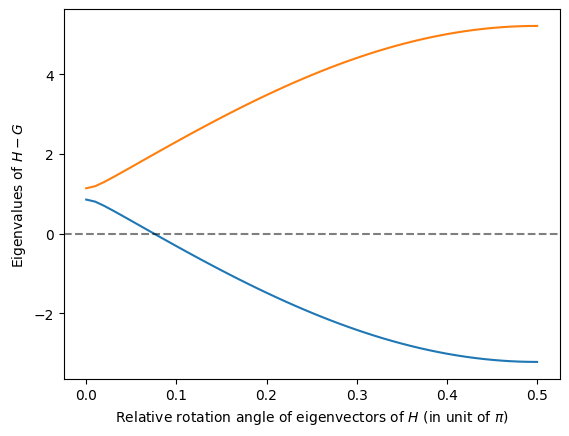

In [9]:
# Generate a rarndom covariance matrix G
G = generate_pd_matrix(N)
lg, vg = np.linalg.eigh(G)  # Eigenvalues and eigenvectors of G

# Add some positive number to the eigenvalues of G and set that as the eigenvalues of H
lambda_pert = np.sort(np.abs(np.random.randn(N)))
lh = lg + lambda_pert

# Rotate the eigenvectors of G and generate H
rel_angle_list = np.linspace(0, 0.5, 51)
ld_list = np.empty((0, 2))  # To store the eigenvalues of D
for rel_angle in rel_angle_list:
    # Generate matrix H
    vh = vg @ rot2d(rel_angle * np.pi)
    H = vh @ np.diag(lh) @ vh.T

    # Difference matric
    D = H - G
    ld_list = np.row_stack((ld_list, np.linalg.eigvalsh(D)))

# Plot
plt.figure()
plt.plot(rel_angle_list, ld_list)
plt.axhline(0.0, c="k", ls="--", alpha=0.5)
plt.xlabel(f"Relative rotation angle of eigenvectors of $H$ (in unit of $\pi$)")
plt.ylabel(r"Eigenvalues of $H-G$")
plt.show()

Initially, $H-G$ is positive definite, shown by all positive eigenvalues.
This is as expected from the second special case I considered above.
As the eigenvectors of $H$ and $G$ become misalign, the smallest eigenvalue of $H-G$ decreases.
At some rotation angle, $H-G$ is no longer be a positive definite matrix.

In [10]:
ld_list_prev = copy.deepcopy(ld_list)
ld_min = np.min(ld_list_prev)
ld_max = np.max(ld_list_prev)

In [11]:
ld_list = np.empty((0, 2))
for ii, rel_angle in tqdm(enumerate(rel_angle_list), total=len(rel_angle_list)):
    # Generate matrix H
    lh = lg + lambda_pert
    vh = vg @ rot2d(rel_angle * np.pi)
    H = vh @ np.diag(lh) @ vh.T

    D = H - G
    ld, vd = np.linalg.eigh(D)
    ld_list = np.row_stack((ld_list, ld))

    eigen_dict = {
        "G": {"eigenvalues": lg, "eigenvectors": vg},
        "H": {"eigenvalues": lh, "eigenvectors": vh},
        "D": {"eigenvalues": ld, "eigenvectors": vd},
    }

    fig, axes = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8), dpi=150)
    # Evolution of eigenvalues
    axes[0].plot(rel_angle_list[: ii + 1], ld_list)
    axes[0].axhline(0.0, c="k", ls="--", alpha=0.5)
    axes[0].set_xlabel(
        f"Relative rotation angle of eigenvectors of $H$ (in unit of $\pi$)"
    )
    axes[0].set_ylabel(r"Eigenvalues of $H-G$")
    axes[0].set_xlim(-0.02, 0.52)
    axes[0].set_ylim(ld_min, ld_max)

    # Evolution of eigenvectors
    plot_cov_matrices(axes[1], eigen_dict, 3)
    axes[1].legend()

    plt.savefig(f"plots/eigenvectors_{ii}.png")
    plt.close()
    # plt.show()

100%|██████████████████████████████████████████████████████████████████| 51/51 [00:21<00:00,  2.39it/s]


In [12]:
filenames = [
    f"plots/eigenvectors_{ii}.png" for ii in range(len(rel_angle_list))
]
images = []
for filename in tqdm(filenames):
    images.append(imageio.imread(filename))
imageio.mimsave("eigenvectors.gif", images)  # For showing the animation below
imageio.mimsave(f"eigenvectors_seed{seed}.mp4", images)

100%|██████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.31it/s]


![Eigenvalues and eignvectors](eigenvectors_seed2023.gif "Eigenvalues and eignvectors")

In [13]:
os.rename("eigenvectors.gif", f"eigenvectors_seed{seed}.gif")

Initially, the red ellipses (representing $G$) is completely encapsulated within the green ellipses (representing $H$).
As we rotate the green ellipse, starting at some rotation angle the red ellipse is no longer completely within the green ellipse - there are parts of the red ellipse that are outside the green ellipse.
If we compare this to the eigenvalues of $D$ (left panel), it seems that $D$ stays to be positive definite as long as the red ellipse is fully within the green ellipse.